<a href="https://colab.research.google.com/github/somosnlp/nlp-de-cero-a-cien/blob/main/2_modelos_secuenciales/LSTM_NLP_clasificador_noticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de texto usando LSTMs con TensorFlow 2.0

Notebook original creado por David Llorente @Narrativa.

## Descargamos el dataset

In [1]:
!wget https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv

--2024-04-03 14:21:57--  https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.08s   

2024-04-03 14:21:58 (62.8 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



## Importamos las librerías requeridas

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.15.0


## Visualizamos el dataset

In [4]:
df = pd.read_csv('bbc-text.csv')

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [7]:
df.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

## Creamos el dataset

In [8]:
articles = []
labels = []

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        article = row[1]
        for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
            article = article.replace('  ', ' ')
        articles.append(article)
print(len(labels))
print(len(articles))

2225
2225


## Definimos algunos parámetros de la red

In [9]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

## Dividimos del dataset

In [10]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))

1780
1780
1780
445
445


## Creamos el Tokenizador

In [11]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

In [12]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[10])

[2431, 1, 225, 4997, 22, 642, 587, 225, 4997, 1, 1, 1662, 1, 1, 2431, 22, 565, 1, 1, 140, 278, 1, 140, 278, 796, 823, 662, 2307, 1, 1144, 1693, 1, 1720, 4998, 1, 1, 1, 1, 1, 4740, 1, 1, 122, 4516, 1, 2, 2873, 1504, 352, 4741, 1, 52, 341, 1, 352, 2172, 3961, 41, 22, 3794, 1, 1, 1, 1, 543, 1, 1, 1, 835, 631, 2366, 347, 4742, 1, 365, 22, 1, 787, 2367, 1, 4303, 138, 10, 1, 3664, 682, 3531, 1, 22, 1, 414, 823, 662, 1, 90, 13, 633, 1, 225, 4997, 1, 599, 1, 1693, 1021, 1, 4999, 808, 1864, 117, 1, 1, 1, 2973, 22, 1, 99, 278, 1, 1606, 1, 543, 493, 1, 1443, 4743, 779, 1320, 1, 1861, 10, 33, 642, 319, 1, 62, 479, 565, 301, 1505, 22, 480, 1, 1, 1665, 1, 797, 1, 3066, 1, 1364, 6, 1, 2431, 565, 22, 2970, 4737, 1, 1, 1, 1, 1, 850, 39, 1825, 675, 297, 26, 979, 1, 882, 22, 361, 22, 13, 301, 1505, 1342, 374, 20, 63, 883, 1096, 4304, 247]


In [13]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

425
200
192
200
186
200


In [14]:
print(train_padded[10])

[2431    1  225 4997   22  642  587  225 4997    1    1 1662    1    1
 2431   22  565    1    1  140  278    1  140  278  796  823  662 2307
    1 1144 1693    1 1720 4998    1    1    1    1    1 4740    1    1
  122 4516    1    2 2873 1504  352 4741    1   52  341    1  352 2172
 3961   41   22 3794    1    1    1    1  543    1    1    1  835  631
 2366  347 4742    1  365   22    1  787 2367    1 4303  138   10    1
 3664  682 3531    1   22    1  414  823  662    1   90   13  633    1
  225 4997    1  599    1 1693 1021    1 4999  808 1864  117    1    1
    1 2973   22    1   99  278    1 1606    1  543  493    1 1443 4743
  779 1320    1 1861   10   33  642  319    1   62  479  565  301 1505
   22  480    1    1 1665    1  797    1 3066    1 1364    6    1 2431
  565   22 2970 4737    1    1    1    1    1  850   39 1825  675  297
   26  979    1  882   22  361   22   13  301 1505 1342  374   20   63
  883 1096 4304  247    0    0    0    0    0    0    0    0    0    0
    0 

In [15]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 200)


## Codificamos las etiquetas usando el Tokenizador



In [16]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1780, 1)
[5]
[4]
[3]
(445, 1)


In [17]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(train_padded[10]))
print('---')
print(train_articles[10])

berlin <OOV> anti nazi film german movie anti nazi <OOV> <OOV> drawn <OOV> <OOV> berlin film festival <OOV> <OOV> final days <OOV> final days member white rose movement <OOV> 21 arrested <OOV> brother hans <OOV> <OOV> <OOV> <OOV> <OOV> tyranny <OOV> <OOV> director marc <OOV> said feeling responsibility keep legacy <OOV> going must <OOV> keep ideas alive added film drew <OOV> <OOV> <OOV> <OOV> trial <OOV> <OOV> <OOV> east germany secret police discovery <OOV> behind film <OOV> worked closely <OOV> relatives including one <OOV> sisters ensure historical <OOV> film <OOV> members white rose <OOV> group first started <OOV> anti nazi <OOV> summer <OOV> arrested dropped <OOV> munich university calling day <OOV> <OOV> <OOV> regime film <OOV> six days <OOV> arrest <OOV> trial saw <OOV> initially deny charges ended <OOV> appearance one three german films <OOV> top prize festival south african film version <OOV> <OOV> opera <OOV> shot <OOV> town <OOV> language also <OOV> berlin festival film enti

## Construimos nuestra red neuronal

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 394694 (1.51 MB)
Trainable params: 394694 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Entrenamos nuestro modelo

In [20]:
num_epochs = 3
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/3
56/56 - 14s - loss: 1.5580 - accuracy: 0.3298 - val_loss: 1.1342 - val_accuracy: 0.5348 - 14s/epoch - 257ms/step
Epoch 2/3
56/56 - 6s - loss: 0.8966 - accuracy: 0.6270 - val_loss: 0.9432 - val_accuracy: 0.6404 - 6s/epoch - 106ms/step
Epoch 3/3
56/56 - 6s - loss: 0.5766 - accuracy: 0.8152 - val_loss: 0.4942 - val_accuracy: 0.8427 - 6s/epoch - 112ms/step


## Visualizamos los resultados

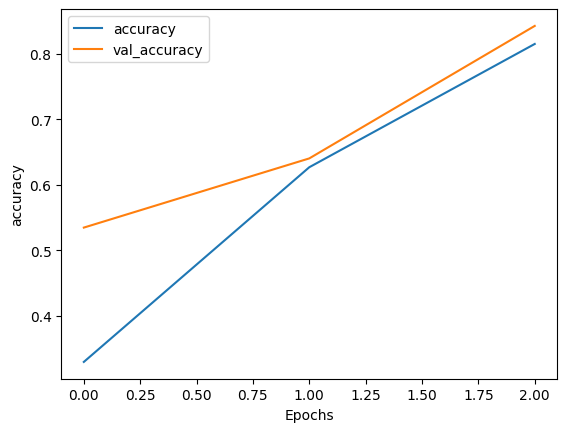

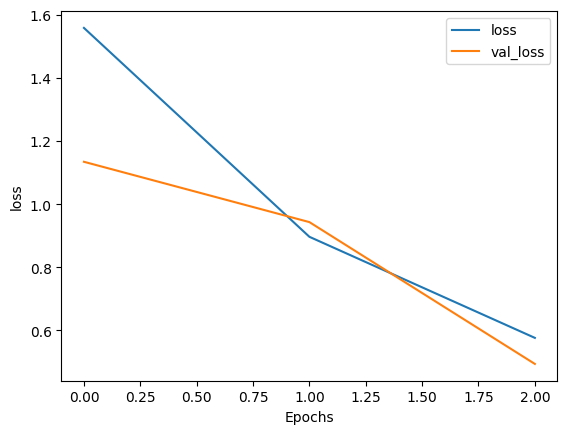

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Probemos nuestro modelo

In [24]:
import pprint
txt = ["Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report."]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
print('Predicción\n')
pprint.pprint(pred)
print()
labels = ['sport', 'bussiness', 'politics', 'tech', 'entertainment']
print(txt[0] + ' ==> ' + labels[np.argmax(pred)])

1/1 [==============================] - 0s 22ms/step
Predicción

array([[2.8097065e-04, 7.5025332e-01, 4.9583204e-02, 7.3176045e-03,
        5.7049703e-02, 1.3551511e-01]], dtype=float32)

Stock market news live updates: S&P 500 rises to record close, Dow up 272 points ahead of July jobs report. ==> bussiness
